## Fundamentals of ML
### Building GPT from scratch

<br />

### ["Attention is all you need" paper (pdf)](https://arxiv.org/abs/1706.03762)

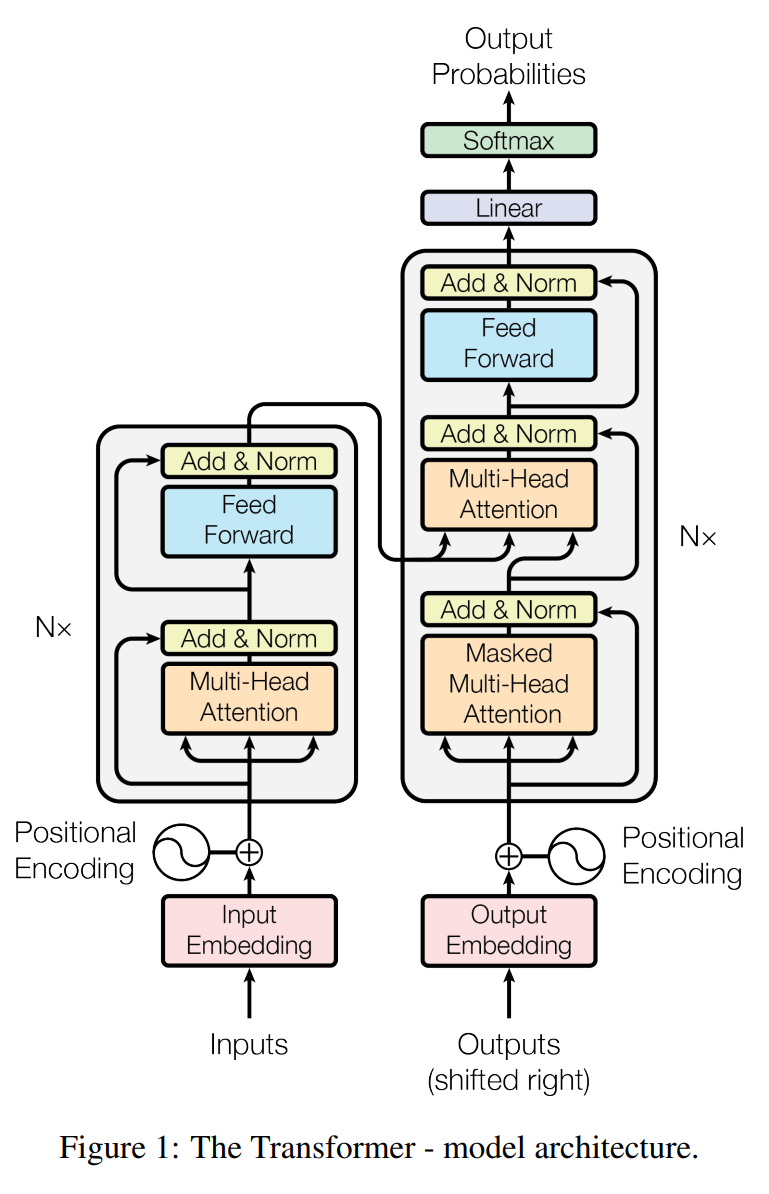

In [1]:
from IPython.display import Image, display

# Extracting the variable for the image path
image_path = "../ml_with_python/images/transformer_model_architecture.png"

# Extracting the function to display the image
def display_image(path):
    display(Image(filename=path))

# Display the image
display_image(image_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [3]:
# read it in to inspect it
with open('resources/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  160228


In [5]:
# let's look at the first 1000 characters
print(text[:100])

St. Petersburg mathematicians and 
their discoveries 
Editors: Nikita Kalinin, Stanislav Smirnov, Ni


In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !%&()*+,-./012345678:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]`abcdefghijklmnopqrstuvwxyz{|}¦¨©±´µ·¸Æ×ıĳŒœˆˇΓΠηλνρστφχψωГКЛОРСТабгдезиклмнорстухцчыь–—’“”•…Ω→∂∆∇∈−∞∧∩≤≥⊂⊥
173


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[66, 67, 67, 1, 78, 66, 63, 76, 63]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earlier will to the GPT look like this

torch.Size([160228]) torch.int64
tensor([47, 78, 11,  1, 44, 63, 78, 63, 76, 77, 60, 79, 76, 65,  1, 71, 59, 78,
        66, 63, 71, 59, 78, 67, 61, 67, 59, 72, 77,  1, 59, 72, 62,  1,  0, 78,
        66, 63, 67, 76,  1, 62, 67, 77, 61, 73, 80, 63, 76, 67, 63, 77,  1,  0,
        33, 62, 67, 78, 73, 76, 77, 22,  1, 42, 67, 69, 67, 78, 59,  1, 39, 59,
        70, 67, 72, 67, 72,  9,  1, 47, 78, 59, 72, 67, 77, 70, 59, 80,  1, 47,
        71, 67, 76, 72, 73, 80,  9,  1, 42, 67])


### [Tokenizer from OpenAI](https://github.com/openai/tiktoken)

In [9]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.n_vocab

50257

In [10]:
enc.encode("Hello, Alex"), enc.encode("Hello, Alexandr") 

([15496, 11, 4422], [15496, 11, 21000, 81])

In [15]:
enc.decode([4422]), enc.decode([15309]), enc.decode([21000]), enc.decode([81])

(' Alex', 'Alex', ' Alexand', 'r')

In [16]:
enc.encode('Alexandr')

[15309, 46273]

In [17]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [18]:
block_size = 8 # contex length
train_data[:block_size+1]

tensor([47, 78, 11,  1, 44, 63, 78, 63, 76])

In [19]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([47]) the target: 78
when input is tensor([47, 78]) the target: 11
when input is tensor([47, 78, 11]) the target: 1
when input is tensor([47, 78, 11,  1]) the target: 44
when input is tensor([47, 78, 11,  1, 44]) the target: 63
when input is tensor([47, 78, 11,  1, 44, 63]) the target: 78
when input is tensor([47, 78, 11,  1, 44, 63, 78]) the target: 63
when input is tensor([47, 78, 11,  1, 44, 63, 78, 63]) the target: 76


In [31]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split, batch_size=batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[62,  1, 64, 73, 76,  1, 78, 66],
        [66, 63,  1, 65, 76, 63, 59, 78],
        [67, 73, 72,  1, 73, 64,  1, 78],
        [11,  1, 11,  1, 11,  1, 11,  1]])
targets:
torch.Size([4, 8])
tensor([[ 1, 64, 73, 76,  1, 78, 66, 63],
        [63,  1, 65, 76, 63, 59, 78,  1],
        [73, 72,  1, 73, 64,  1, 78, 66],
        [ 1, 11,  1, 11,  1, 11,  1, 11]])
----
when input is [62] the target: 1
when input is [62, 1] the target: 64
when input is [62, 1, 64] the target: 73
when input is [62, 1, 64, 73] the target: 76
when input is [62, 1, 64, 73, 76] the target: 1
when input is [62, 1, 64, 73, 76, 1] the target: 78
when input is [62, 1, 64, 73, 76, 1, 78] the target: 66
when input is [62, 1, 64, 73, 76, 1, 78, 66] the target: 63
when input is [66] the target: 63
when input is [66, 63] the target: 1
when input is [66, 63, 1] the target: 65
when input is [66, 63, 1, 65] the target: 76
when input is [66, 63, 1, 65, 76] the target: 63
when input is [66, 63, 1

In [32]:
print(xb) # our input to the transformer

tensor([[62,  1, 64, 73, 76,  1, 78, 66],
        [66, 63,  1, 65, 76, 63, 59, 78],
        [67, 73, 72,  1, 73, 64,  1, 78],
        [11,  1, 11,  1, 11,  1, 11,  1]])


In [33]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (Batch,Time,Channel) = (4, 8, 65)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 173])
tensor(5.7670, grad_fn=<NllLossBackward0>)

)ZьjηBн<WŒ
Z&+•{+“(1a/·b=G×KAH→>ν×PœΓZFDRNц≥ˆv©нCĳс};vmtл{’ЛтQZpˆмT¸12∇ь±\2дзtoÆσk:5AдТh×∩YуNΠ


In [34]:
import math
-math.log(1/173)

5.153291594497779

In [35]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-4)

In [36]:
batch_size = 32
for steps in range(100000): # increase the number of steps for better results..
    
    # sample a batch of data
    xb, yb = get_batch('train', batch_size=batch_size)

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.370316982269287


In [37]:
print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Af telyus, tacaso iathenoin Smprnd Odge t ˆы\` t-MCo Frkil-Jandiccu) g tist. thar Honin Kusofon rsti


## The mathematical trick in self-attention

In [38]:
torch.manual_seed(42)
B, T, C = 4,8,2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [39]:
# the simplest way for tokens to communicate
# we want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # shape is (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [40]:
x[0]

tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624]])

In [41]:
xbow[0]

tensor([[ 1.9269,  1.4873],
        [ 1.4138, -0.3091],
        [ 1.1687, -0.6176],
        [ 0.8657, -0.8644],
        [ 0.5422, -0.3617],
        [ 0.3864, -0.5354],
        [ 0.2272, -0.5388],
        [ 0.1027, -0.3762]])

In [42]:
# toy example illustrating how matrix multiplication can be used for an efficient "weighted aggregation"
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [43]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
# a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [44]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
print(wei)
print(wei.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
torch.Size([8, 8])


In [45]:
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C) matrix multiplication for each b=0..B-1
torch.allclose(xbow, xbow2)

True

In [46]:
# version 3: using Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [48]:
# tril and masked fill operation
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [49]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)        

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (Batch,Time,Channel) = (4, 8, 173)
        pos_emb = self.pos_embedding_table(torch.arange(T)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        logits = self.lm_head(x) # (Batch,Time,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)

            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [50]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ x

out.shape

torch.Size([4, 8, 32])

In [51]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
# out = wei @ x

out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens
- Each example across batch dimension is processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input `Q`,`K` are unit variance, `wei` will be unit variance too and `Softmax` will stay diffuse and not saturate too much. Illustration below

In [52]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [54]:
k.var(), q.var()

(tensor(1.0449), tensor(1.0700))

In [55]:
wei.var()

tensor(1.0918)

In [56]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [57]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [58]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) -> (B,T,head_size)
        q = self.query(x) # (B,T,C) -> (B,T,head_size)
        # compute attention scores ("affinities")
        head_size = k.shape[2]
        wei = q @ k.transpose(-2,-1) * head_size**-0.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


In [60]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('resources/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # with residual connections and prenormalization (linnorm before computations)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, _ = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = Transformer()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.223661 M parameters
step 0: train loss 5.2961, val loss 5.3109
step 100: train loss 2.7145, val loss 2.7483
step 200: train loss 2.5497, val loss 2.6009
step 300: train loss 2.4561, val loss 2.5173
step 400: train loss 2.3928, val loss 2.4521
step 500: train loss 2.2777, val loss 2.3616
step 600: train loss 2.2006, val loss 2.2782
step 700: train loss 2.1152, val loss 2.2196
step 800: train loss 2.0467, val loss 2.1641
step 900: train loss 1.9938, val loss 2.1325
step 1000: train loss 1.9471, val loss 2.0755
step 1100: train loss 1.9054, val loss 2.0513
step 1200: train loss 1.8515, val loss 2.0090
step 1300: train loss 1.8015, val loss 1.9547
step 1400: train loss 1.7809, val loss 1.9571
step 1500: train loss 1.7365, val loss 1.9319
step 1600: train loss 1.7180, val loss 1.9131
step 1700: train loss 1.6856, val loss 1.8901
step 1800: train loss 1.6697, val loss 1.8772
step 1900: train loss 1.6439, val loss 1.8638
step 2000: train loss 1.6225, val loss 1.8491
step 2100: train loss 1.

In [61]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [62]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs (columns)

(tensor(0.1469), tensor(0.8803))

In [63]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features (rows)

(tensor(-3.5763e-09), tensor(1.0000))

### [Dropout paper (Srivastava, Hinton, Krizhevsky, Sutskever, Salakhutdinov)](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

In [64]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

### ["LM are few-shot learners" paper](https://arxiv.org/abs/2005.14165)

### What else can you look at?

1. [https://openai.com/blog/chatgpt](https://openai.com/blog/chatgpt) — introducing ChatGPT from OpenAI
2. [https://www.youtube.com/watch?v=kCc8FmEb1nY](https://www.youtube.com/watch?v=kCc8FmEb1nY) — lecture of Andrej Karpathy
3. [https://bbycroft.net/](https://bbycroft.net/) — nice visualization of GPTs
